In [1]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [2]:
from fastcore.utils import *
from fastcore.test import *

from datetime import timedelta

import polars as pl
import pandas as pd
import numpy as np

import altair as alt
import vegafusion as vf
vf.enable(row_limit = int(1e6))

import astropy.constants as constep

from ids_finder.utils import *

## Setup

In [3]:
%%markdown
%pip install rpy2 rpy2-arrow

%pip install rpy2 rpy2-arrow


In [4]:
%load_ext rpy2.ipython

In [5]:
import rpy2
import rpy2_arrow.arrow as pyra
from rpy2.robjects.packages import importr

In [6]:
%%R
library(ggplot2)
library(ggpubr)
library(viridis)

library(glue)
library(arrow)

Loading required package: viridisLite


In [7]:
#| code-summary: helper functions to convert between `python` and `R` dataframes

base = importr('base')

conv_pl = rpy2.robjects.conversion.Converter(
    'Pandas to pyarrow',
    template=pyra.converter)

@conv_pl.py2rpy.register(pl.DataFrame)
def py2rpy_pandas(dataf: pl.DataFrame):
    pa_tbl = dataf.to_arrow()
    return base.as_data_frame(pa_tbl)
    # return pyra.converter.py2rpy(pa_tbl) # NOTE: not working for ggplot2

conv_pl = rpy2.ipython.rmagic.converter + conv_pl

In [8]:

# read candidates from files in current directory

tau = timedelta(seconds=60)

jno_fp = Path(f'../data/jno_candidates_tau_{tau.seconds}.parquet')
thb_fp = Path(f'../data/thb_candidates_sw_tau_{tau.seconds}.parquet')
sta_fp = Path(f'../data/sta_candidates_tau_{tau.seconds}.parquet')


jno_candidates = pl.scan_parquet(jno_fp).collect()
thb_candidates = pl.scan_parquet(thb_fp).collect()
sta_candidates = pl.scan_parquet(sta_fp).collect()

jno_data_fp = Path(f'../data/jno_data_*.parquet')

jno_data = pl.scan_parquet(jno_data_fp)

In [9]:
from ydata_profiling import ProfileReport

/Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [16]:
jno_candidates.columns

['count',
 'time',
 'B_std',
 'B_std_prev',
 'count_prev',
 'B_std_next',
 'count_next',
 'index_std',
 'B_mean',
 'dBX_vec',
 'dBY_vec',
 'dBZ_vec',
 'dB_vec',
 'index_diff',
 'B_combined_std',
 'B_added_std',
 'index_fluctuation',
 'tstart',
 'tstop',
 'd_star',
 'd_time',
 'd_tstart',
 'd_tstop',
 'threshold',
 'B',
 'B_n',
 'BnOverB',
 'Q_mva',
 'Vl_x',
 'Vl_y',
 'Vl_z',
 'dB',
 'dBOverB',
 'dBOverB_max',
 'eig0',
 'eig1',
 'eig2',
 'type',
 'rotation_angle',
 'BX',
 'BY',
 'BZ',
 'X',
 'Y',
 'Z']

In [22]:
df = jno_candidates.select(["time", 'index_diff', "B", 'B_n', 'BnOverB', 'dB', 'dBOverB', 'rotation_angle', 'type', "X"]).to_pandas()

In [23]:
profile = ProfileReport(df, title="JUNO Candidates Report")
profile.to_file("jno.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 316.86it/s]


In [15]:
from functools import reduce

@patch
def sel(self: pl.LazyFrame | pl.DataFrame, **kwargs):
    predicates = []
    for k, v in kwargs.items():
        if isinstance(v, slice):
            predicate = pl.col(k).is_between(v.start, v.stop)
        else:
            predicate = pl.col(k) == v
        predicates.append(predicate)
    
    return self.filter(reduce(operator.and_, predicates))

In [16]:
jno_candidates.sel(BnOverB=slice(0.9, 1.0))

count,time,B_std,B_std_prev,count_prev,B_std_next,count_next,index_std,B_mean,dBX_vec,dBY_vec,dBZ_vec,dB_vec,index_diff,B_combined_std,B_added_std,index_fluctuation,tstart,tstop,d_star,d_time,d_tstart,d_tstop,threshold,B,B_n,BnOverB,Q_mva,Vl_x,Vl_y,Vl_z,dB,dBOverB,dBOverB_max,eig0,eig1,eig2,type,rotation_angle,BX,BY,BZ,X,Y,Z
u32,datetime[ns],f64,f64,u32,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],datetime[ns],f64,datetime[ns],datetime[ns],datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
60,2011-08-25 20:23:30,0.78154,0.2342,60,0.34695,60,2.252597,3.768694,-0.78,0.38,-0.95,1.286585,0.341387,0.72147,0.581151,1.24145,2011-08-25 20:23:00,2011-08-25 20:24:00,0.854664,2011-08-25 20:23:13.000000503,2011-08-25 20:23:07.000000504,2011-08-25 20:23:17.000000504,0.213666,3.726647,3.617902,0.97082,11.619775,0.602407,-0.294687,0.741799,-0.057171,0.015341,0.057746,0.533492,0.077238,0.006647,"""RD""",5.015897,-0.9,3.3,1.55,1.5190e8,-3.213,-0.122
60,2011-08-26 15:33:30,0.495082,0.159579,60,0.150715,60,3.102428,4.419419,-0.87,-0.29,0.83,1.236891,0.279876,0.659447,0.310294,2.125235,2011-08-26 15:33:00,2011-08-26 15:34:00,0.199875,2011-08-26 15:33:05.000000480,2011-08-26 15:33:04.000000480,2011-08-26 15:33:07.000000480,0.049969,4.563244,4.429539,0.9707,15.775335,-0.869856,-0.206718,0.447904,0.089485,0.01961,0.01961,0.029173,0.000108,0.000007,"""RD""",4.981168,-0.9,3.86,2.21,1.5204e8,-3.28,-0.117
60,2011-08-26 21:53:30,1.19594,0.257492,60,0.275564,60,4.339971,5.21436,-1.25,-0.6,-2.05,2.474874,0.474627,0.824439,0.533056,1.546628,2011-08-26 21:53:00,2011-08-26 21:54:00,1.000662,2011-08-26 21:53:26.000000442,2011-08-26 21:53:24.000000442,2011-08-26 21:53:28.000000442,0.250166,5.109117,4.973482,0.973452,3.95694,0.293105,0.05837,0.954297,-0.10156,0.019878,0.040261,0.972255,0.003168,0.000801,"""RD""",26.643474,-2.6,4.28,0.43,1.5209e8,-3.302,-0.115
60,2011-08-27 13:33:30,1.405359,0.579488,58,0.468913,60,2.425175,4.746786,1.2,-0.54,2.89,3.175484,0.668976,1.4414,1.0484,1.374856,2011-08-27 13:33:00,2011-08-27 13:34:00,0.977471,2011-08-27 13:33:40.000000471,2011-08-27 13:33:31.000000471,2011-08-27 13:33:43.000000471,0.244368,4.615878,4.425435,0.958742,5.205196,0.796363,-0.303065,0.52341,0.197537,0.042795,0.076565,1.151236,0.097239,0.018681,"""RD""",28.779545,-1.02,3.38,3.21,1.5222e8,-3.356,-0.111
60,2011-08-28 01:12:00,1.109904,0.419852,60,0.500323,60,2.218374,5.928908,-1.07,0.21,0.44,1.17584,0.198323,1.164051,0.920175,1.265032,2011-08-28 01:11:30,2011-08-28 01:12:30,0.534462,2011-08-28 01:11:37.000000525,2011-08-28 01:11:30.000000525,2011-08-28 01:11:50.000000525,0.133616,6.177344,5.978811,0.967861,5.28575,0.94259,-0.001627,0.333948,0.418277,0.067712,0.084536,0.566257,0.068842,0.013024,"""RD""",10.251807,-1.76,5.83,1.51,1.5232e8,-3.396,-0.108
60,2011-08-28 11:43:30,1.056976,0.471537,60,0.396776,60,2.241556,4.860351,1.98,-0.11,0.17,1.990327,0.409503,1.782175,0.868313,2.052456,2011-08-28 11:43:00,2011-08-28 11:44:00,0.710387,2011-08-28 11:43:13.000000461,2011-08-28 11:43:01.000000461,2011-08-28 11:43:15.000000461,0.177597,4.905344,4.805237,0.979592,3.027699,0.848428,-0.385786,0.362406,0.314742,0.064163,0.092812,0.880026,0.02918,0.009638,"""RD""",26.726961,0.38,5.06,0.71,1.5241e8,-3.432,-0.104
60,2011-08-28 22:30:00,1.346526,0.451792,60,0.358241,60,2.980409,5.434511,1.34,0.94,-0.44,1.694934,0.311883,0.87414,0.810033,1.079141,2011-08-28 22:29:30,2011-08-28 22:30:30,1.235516,2011-08-28 22:30:17.000000520,2011-08-28 22:30:15.000000520,2011-08-28 22:30:20.000000520,0.308879,5.472901,5.01149,0.915692,3.687091,-0.721393,-0.185279,0.667281,0.293186,0.05357,0.070758,1.771673,0.00124,0.000336,"""RD""",33.326676,-1.62,5.03,-0.43,1.5251e8,-3.469,-0.101
60,2011-08-31 09:26:00,0.736978,0.134255,60,0.068252,60,5.489377,2.589827,0.77,1.1,-0.01,1.342758,0.518474,0.686758,0.202507,3.391276,2011-08-31 09:25:30,2011-08-31 09:26:30,0.614024,2011-08-31 09:25:59.000000536,2011-08-31 09:25:57.000000536,2011-08-31 0

In [17]:
if Path("../data/candidates.csv").exists():
    all_candidates = pl.read_csv("../data/candidates.csv")
else:
    all_candidates = pl.concat(
    [
        jno_candidates.with_columns(sat=pl.lit("JNO")),
        thb_candidates.with_columns(sat=pl.lit("THB")),
        sta_candidates.with_columns(sat=pl.lit("STA")).with_columns(pl.selectors.float().cast(pl.Float64)),
    ],
    how="diagonal"
)
    all_candidates.write_csv()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

In [14]:
sns.lineplot(x="time", y="dBOverB", hue="sat", data=all_candidates)

KeyboardInterrupt: 

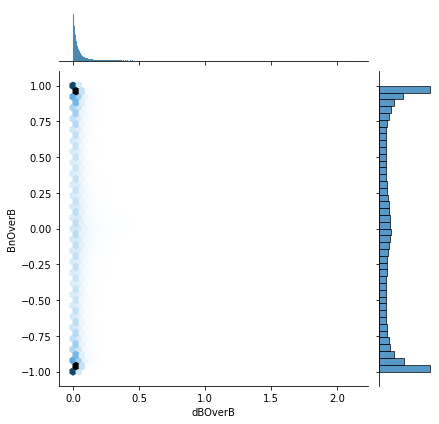

In [11]:
sns.jointplot(
    all_candidates,
    x='dBOverB', y='BnOverB',
    # kind='kde',
    kind="hex",
)

In [138]:

au_in_km = const.au.to("km").value

jno_dist_cols = ["X", "Y", "Z"]

jno_candidates = jno_candidates.with_columns(
    pl_norm(jno_dist_cols).alias("distance"),
).with_columns(
    (pl.col(["X", "distance"]) / au_in_km).map_alias(lambda col: col+"_in_AU"),
).sort("time")

jno_candidates_filtered = jno_candidates.filter(
        pl.col("time") < pd.Timestamp("2016-05-01") # There is a sudden increase in the number of TD candidates after this date
)

In [139]:
%R -i jno_candidates -c conv_pl
%R -i thb_candidates -c conv_pl
%R -i sta_candidates -c conv_pl
%R -i jno_candidates_filtered -c conv_pl

## Analysis

#### Utils

In [24]:
%%R
# Save the plot, if filename is provided
save_plot <- function(filename = NULL) {
  if (!is.null(filename)) {
    ggsave(filename = glue("../images/{filename}.png"))
    ggsave(filename = glue("../images/{filename}.pdf"))
  }
}

### Magnetic field strength vs. distance

In [10]:
%%markdown

file = f"../data/jno_*.parquet"
lazy_df = pl.scan_parquet(file)


file = f"../data/jno_*.parquet"
lazy_df = pl.scan_parquet(file)


In [11]:
%%markdown
b_cols = ["BX", "BY", "BZ"]

every = "3d"
b_df = (
    lazy_df.with_columns(
        pl_norm(b_cols).alias("B"),)
    .sort("time")
    .group_by_dynamic("time", every=every)
    .agg(
        pl.mean("B").alias("B_mean"),
    )
    .collect()
)

b_cols = ["BX", "BY", "BZ"]

every = "3d"
b_df = (
    lazy_df.with_columns(
        pl_norm(b_cols).alias("B"),)
    .sort("time")
    .group_by_dynamic("time", every=every)
    .agg(
        pl.mean("B").alias("B_mean"),
    )
    .collect()
)


In [12]:
%%markdown
alt.Chart(b_df).mark_line().encode(
    x="time",
    y="B_mean",
)

alt.Chart(b_df).mark_line().encode(
    x="time",
    y="B_mean",
)


In [13]:
%%markdown
binwidth = 0.1

b_df = (
    lazy_df.with_columns(
        (pl.col('X')/au_in_km / binwidth).floor().alias('bin_group_id').cast(pl.Int64),
        pl_norm(b_cols).alias("B"),
    ).group_by("bin_group_id").agg(
        pl.mean("B").alias("B_mean"),
    ).with_columns(
        (pl.col("bin_group_id") * binwidth).alias("binned_distance"),
    ).collect()
)

binwidth = 0.1

b_df = (
    lazy_df.with_columns(
        (pl.col('X')/au_in_km / binwidth).floor().alias('bin_group_id').cast(pl.Int64),
        pl_norm(b_cols).alias("B"),
    ).group_by("bin_group_id").agg(
        pl.mean("B").alias("B_mean"),
    ).with_columns(
        (pl.col("bin_group_id") * binwidth).alias("binned_distance"),
    ).collect()
)


In [14]:
%%markdown

alt.Chart(b_df).mark_line().encode(
    x=alt.X("binned_distance").title("Distance from Sun (AU)"),
    y=alt.Y("B_mean").title("Magnetic Field Strength (nT)"),
)


alt.Chart(b_df).mark_line().encode(
    x=alt.X("binned_distance").title("Distance from Sun (AU)"),
    y=alt.Y("B_mean").title("Magnetic Field Strength (nT)"),
)


### Distance and Occurrence rates versus time

In [15]:
%%markdown
properties = {'width': 900, 'height': 150}

chart1 = alt.Chart(candidates_pl).mark_point().encode(
    x=alt.X('yearmonthdate(time)').axis(labels=False, title=None),
    y=alt.Y('mean(distance_in_AU)').axis(title='Distance (AU)'),
).properties(**properties)

chart2 = alt.Chart(candidates_pl).mark_point().encode(
    x='yearmonth(time)',
    y='count()',
    color = 'type',
    row='type'
).properties(**properties)

chart1 & chart2

properties = {'width': 900, 'height': 150}

chart1 = alt.Chart(candidates_pl).mark_point().encode(
    x=alt.X('yearmonthdate(time)').axis(labels=False, title=None),
    y=alt.Y('mean(distance_in_AU)').axis(title='Distance (AU)'),
).properties(**properties)

chart2 = alt.Chart(candidates_pl).mark_point().encode(
    x='yearmonth(time)',
    y='count()',
    color = 'type',
    row='type'
).properties(**properties)

chart1 & chart2


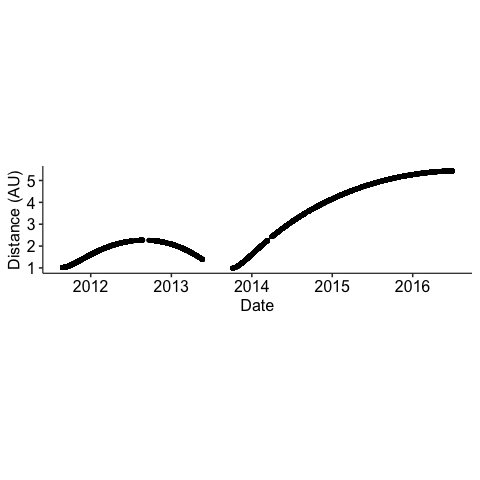

In [16]:
%%R -i jno_candidates -c conv_pl

p <- ggplot(jno_candidates, aes(x = time, y = distance_in_AU)) + 
  geom_point() + # Plot distance by date
  labs(x = "Date", y = "Distance (AU)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)

print(p)

# save_plot(filename = "distance_by_date")

The following codes deal with data gap better by filling the gap with the `null` value.

In [17]:
every = pd.Timedelta("3d")
base_amplification_factor = every / pd.Timedelta("1d")

temp_df = (
    jno_candidates.filter(
        pl.col("time") < pd.Timestamp("2016-05-01") # There is a sudden increase in the number of TD candidates after this date
    )
    .with_columns(
        pl.col("time").dt.truncate(every).alias("truncated_time")
    )
    .group_by("truncated_time")
    .agg(
        pl.count()/base_amplification_factor,
        pl.mean("distance_in_AU"),
    )
)

df = temp_df.upsample("truncated_time", every=every)

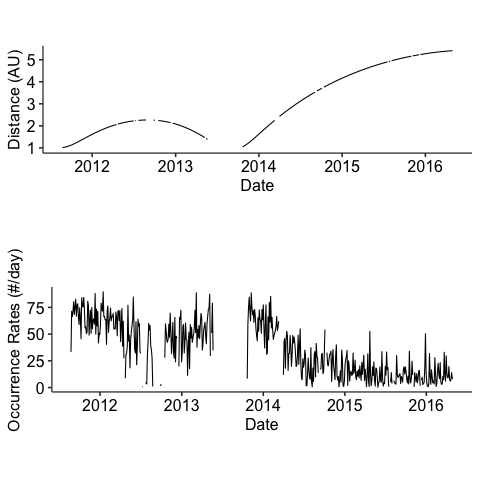

In [18]:
%%R -i df -c conv_pl

df$date <- as.Date(df$truncated_time)
p1 <- ggplot(df, aes(x = date, y = distance_in_AU)) + 
  geom_line() + # Plot distance by date
  labs(x = "Date", y = "Distance (AU)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)
  
p2 <- ggplot(df, aes(x = date, y = count)) + 
  geom_line() + # Plot distance by date
  labs(x = "Date", y = "Occurrence Rates (#/day)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)

p <- ggarrange(p1, p2, nrow = 2)

filename <- "distance_and_or"
# ggsave(glue("../images/{filename}.png"))
# ggsave(glue("../images/{filename}.pdf"))
p

### Occurrence rates versus time of different types

Plot the occurernce rate of each type of IDs as a function of time

In [100]:
%%R
plot_count_raw <- function(data, bin_width = 5) {
  # Transform date column
  data$date_only <- as.Date(data$time)
  
  # Plot
  p <- ggplot(data, aes(x = date_only)) + 
    geom_freqpoly(aes(color = "All"), binwidth = bin_width) + # Overall frequency by day
    geom_freqpoly(aes(color = type), binwidth = bin_width) + # Frequency by day split by type
    labs(x = "Date") +
    theme_pubr(base_size = 16) +
    theme(
      aspect.ratio=0.25,
      )
  
  # Print the plot
  print(p)
  
  return(p)
}

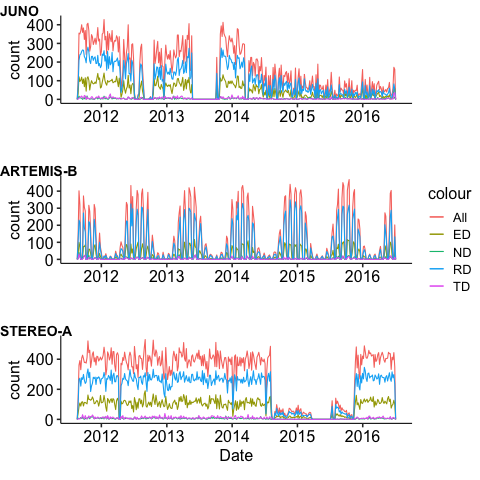

In [99]:
%%R
p1 <- plot_count_raw(jno_candidates)
p2 <- plot_count_raw(thb_candidates)
p3 <- plot_count_raw(sta_candidates)

p <- ggarrange(
    p1 + rremove("xlab"),
    p2 + rremove("xlab"), p3, 
    nrow = 3, align = 'hv', 
    labels=list("JUNO", "ARTEMIS-B", "STEREO-A"), hjust=0,
    legend = 'right', common.legend = TRUE)

# save_plot("count_raw_multi")
p

As we can see different types of IDs have different Occurrence rates. To demonstrate their relative change, amplify TD-like IDs by 10 times.

In [28]:
import pandas as pd
import polars as pl


def get_count_by_type(candidates: pl.DataFrame, truncation_delta="5d"):
    every = pd.Timedelta(truncation_delta)
    base_amplification_factor = every / pd.Timedelta("1d")
    amplification_factors = {
        "RD": 1 / base_amplification_factor,
        "ED": 1 / base_amplification_factor,
        "TD": 10 / base_amplification_factor,
        "ND": 10 / base_amplification_factor,
    }

    temp_df = (
        candidates.with_columns(
            pl.col("time").dt.truncate(every).alias("truncated_time")
        )
        .group_by("truncated_time", "type")
        .agg(
            pl.count(),
        )
    )

    type_dfs = []
    for type, group in temp_df.group_by("type"):
        type_df = (
            group.sort("truncated_time")
            .upsample("truncated_time", every=every)
            .with_columns(
                pl.col("type").fill_null(type),
                (pl.col("count") * amplification_factors[type]),
            )
        )
        type_dfs.append(type_df)

    df = pl.concat(type_dfs)
    return df

In [107]:
%%R
plot_count_am <- function(df) {
  tmp <- df %>%
    mutate(name2=type)
  tmp$date <- as.Date(tmp$truncated_time)
  tmp$type <- factor(tmp$type, levels = c("RD", "ED", "TD", "ND"))

  p <- tmp %>%
    ggplot( aes(date, count)) +
      geom_line( data=tmp %>% dplyr::select(-type), aes(group=name2), color="grey", linewidth=0.5, alpha=0.5) +
      geom_line( aes(color=type), color="#69b3a2")+
      facet_grid(type ~ .) +
      labs(x = "Date", y = "Occurrence Rates (#/day)") +
      theme_pubr(base_size = 16) +
      theme(aspect.ratio=0.25)

  # Print the plot
  print(p)
  
  return(p)
}

In [ ]:
# Call the function with appropriate arguments
jno_count_df = get_count_by_type(
    jno_candidates
    .filter(pl.col("time") < pd.Timestamp("2016-05-01")) # There is a sudden increase in the number of TD candidates after this date
)

In [ ]:
%%R -i jno_count_df -c conv_pl
plot_count_am(jno_count_df)
# save_plot('jno_count_am')

In [ ]:
thb_count_df = get_count_by_type(
    thb_candidates
)

In [ ]:
%%R -i thb_count_df -c conv_pl
plot_count_am(thb_count_df)
# save_plot('thb_count_am')

#### Histogram of Occurrence rates (not normalized)

In [ ]:
jno_candidates_rd_like = jno_candidates.filter(
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

jno_candidates_td_like = jno_candidates.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

thb_candidates_rd_like = thb_candidates.filter(
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

thb_candidates_td_like = thb_candidates.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

In [ ]:
%R -i jno_candidates -c conv_pl
%R -i jno_candidates_rd_like -c conv_pl
%R -i jno_candidates_td_like -c conv_pl
%R -i thb_candidates -c conv_pl
%R -i thb_candidates_rd_like -c conv_pl
%R -i thb_candidates_td_like -c conv_pl

In [ ]:
%%R

p1 <- gghistogram(jno_candidates, x = "time",
   rug = TRUE,
   color = "type", fill = "type",
   )

p2 <- gghistogram(jno_candidates_rd_like, x = "time",
   rug = TRUE,
   color = "type", fill = "type",
   )

p3 <- gghistogram(jno_candidates_td_like, x = "time",
   rug = TRUE,
   color = "type", fill = "type",
   )

p <- ggarrange(p1, p2, p3, nrow = 3)
p

In [ ]:
%%R

p1 <- gghistogram(thb_candidates, x = "time",
   rug = TRUE,
   color = "type", fill = "type",
   )

p2 <- gghistogram(thb_candidates_rd_like, x = "time",
   rug = TRUE,
   color = "type", fill = "type",
   )

p3 <- gghistogram(thb_candidates_td_like, x = "time",
   rug = TRUE,
   color = "type", fill = "type",
   )

p <- ggarrange(p1, p2, p3, nrow = 3)
p

#### Histogram of Occurrence rates (normalized)

In [36]:
def normalize_count(
    count_df: pl.DataFrame, # the dataframe with count to be normalized
    data: pl.DataFrame, # the data used to calculate the duration ratio
    s_resolution, l_resolution
):
    duration_df = (
        data.group_by_dynamic("time", every=s_resolution)
        .agg(pl.lit(1).alias("availablity"))
        .upsample("time", every=s_resolution)
        .group_by_dynamic("time", every=l_resolution)
        .agg(
            (pl.sum("availablity") * s_resolution / l_resolution).alias(
                "duration_ratio"
            )
        )
    )

    count_normalized_df = count_df.join(
        duration_df, left_on="truncated_time", right_on="time"
    ).with_columns((pl.col("count") / pl.col("duration_ratio")).alias("count"))
    
    return count_normalized_df

In [47]:
s_resolution = timedelta(minutes=1)
l_resolution = timedelta(days=30)

In [103]:
sat = 'jno'
files = f"../data/{sat}_data_*.parquet"

data = pl.scan_parquet(files).set_sorted('time').collect()
jno_count_df = get_count_by_type(jno_candidates, l_resolution)
jno_count_normalized_df = normalize_count(jno_count_df, data, s_resolution, l_resolution)

In [140]:
jno_count_filtered_df = get_count_by_type(jno_candidates_filtered, l_resolution)
jno_count_normalized_filtered_df = normalize_count(jno_count_filtered_df, data, s_resolution, l_resolution)

In [ ]:
sat = 'thb'
files = f"../data/{sat}_data_sw.parquet"

data = pl.scan_parquet(files).set_sorted('time').collect()
thb_count_df = get_count_by_type(thb_candidates, l_resolution)
thb_count_normalized_df = normalize_count(thb_count_df, data, s_resolution, l_resolution)

In [38]:
sat = 'STA'
files = f"../data/{sat}_data_downsampled.parquet"

data = pl.scan_parquet(files).set_sorted('time').collect()
sta_count_df = get_count_by_type(sta_candidates, l_resolution)
sta_count_normalized_df = normalize_count(sta_count_df, data, s_resolution, l_resolution)

In [141]:
%R -i thb_count_normalized_df -c conv_pl
%R -i sta_count_normalized_df -c conv_pl
%R -i jno_count_normalized_df -c conv_pl
%R -i jno_count_normalized_filtered_df -c conv_pl

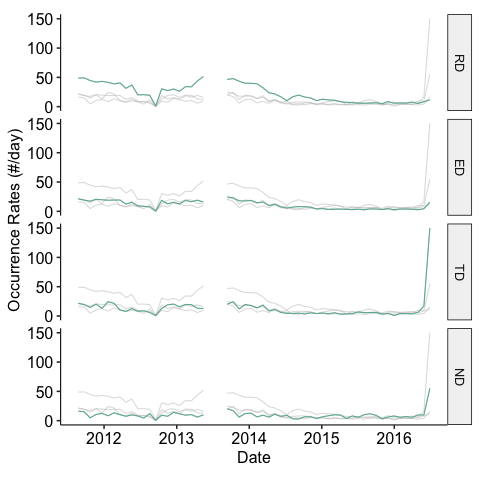

In [145]:
%%R
p1 <- plot_count_am(jno_count_normalized_df)

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


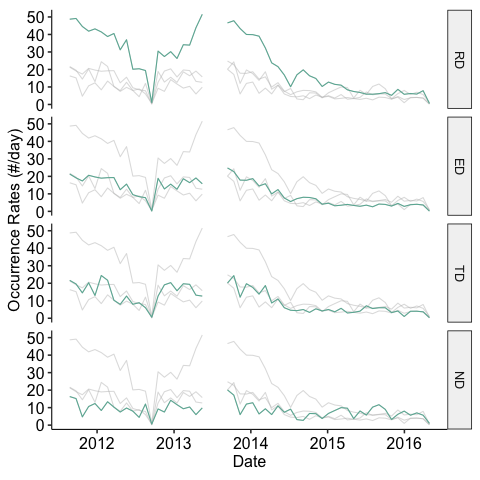

In [144]:
%%R
p1_f <- plot_count_am(jno_count_normalized_filtered_df)
save_plot("count_am_jno_filtered")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


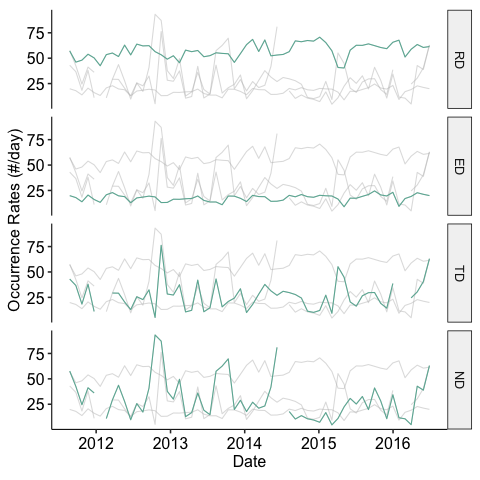

In [147]:
%%R
p2 <- plot_count_am(thb_count_normalized_df)
save_plot("count_am_thb")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


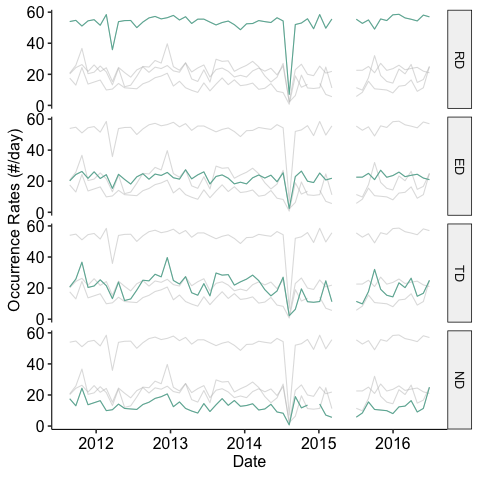

In [146]:
%%R
p3 <- plot_count_am(sta_count_normalized_df)
save_plot("count_am_sta")

### Occurrence rates versus distance

In [ ]:
temp_candidates_pl = jno_candidates.filter(
    pl.col("time") > pd.Timestamp("2013-06-01")  # Where distance increases singularly
)

In [ ]:
%%R -i temp_candidates_pl -c conv_pl
gghistogram(temp_candidates_pl, x="distance_in_AU", rug=TRUE, color="type", fill="type", binwidth=0.1) + 
  labs(x="Distance (AU)", y="Count")

In [ ]:
jno_candidates_rd_like = temp_candidates_pl.filter(  
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

jno_candidates_td_like = temp_candidates_pl.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

In [ ]:
%%R -i candidates_rd_like -c conv_pl

gghistogram(candidates_rd_like, x="distance_in_AU", rug=TRUE, color="type", fill="type", binwidth=0.1) + 
  labs(x="Distance (AU)", y="Count") +
  theme_pubr(base_size = 16)

In [ ]:
%%R -i candidates_td_like -c conv_pl

gghistogram(candidates_td_like, x="distance_in_AU", rug=TRUE, color="type", fill="type", binwidth=0.1) + 
  labs(x="Distance (AU)", y="Count") +
  theme_pubr(base_size = 16)

In [ ]:
binwidth = 0.1
temp_df = temp_candidates_pl.with_columns(
    (pl.col('distance_in_AU')/binwidth).floor().alias('bin_group_id').cast(pl.Int64),
).group_by("bin_group_id",'type').agg(
    (pl.max("time") - pl.min("time")).alias("duration"),
    pl.col('distance_in_AU').mean().alias("mean_distance"),
    pl.count()
).with_columns(
    (pl.col("duration") / pd.Timedelta(hours=24)).alias("duration_in_days"),
).filter(
    pl.col("duration_in_days") > 1 # filter out candidates that occur within 1 day
).with_columns(
    (pl.col("count") / pl.col("duration_in_days")).alias("occurrence_rate")
).sort(
    "bin_group_id"
)

In [ ]:
_ = pl.DataFrame({'bin_group_id': pl.arange(temp_df['bin_group_id'].min(), temp_df['bin_group_id'].max()+1, eager=True)})

type_dfs = []
for type, jno_fp in temp_df.group_by("type"):
    type_df = _.join(jno_fp, on="bin_group_id", how="left").with_columns(
            pl.col("type").fill_null(type),
        )
    type_dfs.append(type_df)

or_df = pl.concat(type_dfs).with_columns(
    (pl.col("bin_group_id") * binwidth).alias("binned_distance"),
)

In [ ]:
%%R -i or_df -c conv_pl
p <- ggplot(or_df, aes(x=binned_distance, y=occurrence_rate, color=type)) +
    geom_point() +
    geom_line() +
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

In [ ]:
jno_candidates_rd_like = or_df.filter(
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

jno_candidates_td_like = or_df.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

In [ ]:
%%R -i candidates_rd_like -c conv_pl
p <- ggplot(candidates_rd_like, aes(x=binned_distance, y=occurrence_rate, color=type)) +
    geom_point() +
    geom_line() +
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance_rd"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

In [ ]:
%%R -i candidates_td_like -c conv_pl
p <- ggplot(candidates_td_like, aes(x=binned_distance, y=occurrence_rate, color=type)) +
    geom_point() +
    geom_line() +
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance_td"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

In [ ]:
%%R -i candidates_rd_like -c conv_pl
p <- ggscatter(candidates_rd_like, x = "mean_distance", y = "occurrence_rate",
        color = "type",
        add = "loess",  # Add regressin line
        add.params = list(fill = "lightgray"), # Customize reg. line
        shape = 21, size=3, # Points color, shape and size
        conf.int = TRUE, # Add confidence interval
        cor.coef = TRUE, # Add correlation coefficient. see ?stat_cor
        cor.coeff.args = list(method = "pearson", label.x = 3, label.sep = "\n")
    ) + 
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance_rd"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

In [ ]:
%%R -i candidates_td_like -c conv_pl
p <- ggscatter(candidates_td_like, x = "mean_distance", y = "occurrence_rate",
        color = "type",
        add = "loess",  # Add regressin line
        add.params = list(fill = "lightgray"), # Customize reg. line
        shape = 21, size=3, # Points color, shape and size
        conf.int = TRUE, # Add confidence interval
        cor.coef = TRUE, # Add correlation coefficient. see ?stat_cor
        cor.coeff.args = list(method = "pearson", label.x = 3, label.sep = "\n")
    ) + 
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance_td_fit"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

### Plotting candidates of different types of discontinuities

In [ ]:
# alt.Chart(candidates).mark_point().encode(
#     x='yearmonth(time)',
#     y='count()',
#     color='type',
# )

In [ ]:
alt.Chart(jno_candidates.to_pandas()).mark_point().encode(
    x='X',
    y='count(type)',
    color='type',
)

In [ ]:
plot_candidates(jno_candidates, candidate_type='TD')

In [ ]:
plot_candidates(jno_candidates, candidate_type='RD')

In [ ]:
plot_candidates(jno_candidates, candidate_type='ED')

In [ ]:
plot_candidates(jno_candidates, candidate_type='ND')

### Occurrence rates

In [ ]:
# calculate the Occurrence rates of different types of ID
def Occurrence_rate(candidates, candidate_type):
    return len(candidates[candidates['type'] == candidate_type]) / len(candidates)

def time_Occurrence_rate(candidates):
    if len(candidates) <= 1:
        return None
    else:
        return (candidates.iloc[-1]['tstop'] - candidates.iloc[0]['tstart']) / (len(candidates) -1)

CANDIDATE_TYPES = ['RD', 'TD', 'ED', 'ND']

for candidate_type in CANDIDATE_TYPES:
    logger.info(f"Occurrence rate of {candidate_type}: {Occurrence_rate(jno_candidates, candidate_type)}")
    logger.info(f"Time Occurrence rate of {candidate_type}: {time_Occurrence_rate(jno_candidates[jno_candidates['type'] == candidate_type])}")

In [ ]:
pdp.ColByFrameFunc("R", lambda df: df[['X','Y', 'Z']].apply(np.linalg.norm, axis=1), func_desc='calculating R')(jno_candidates)

In [ ]:
jno_candidates.plot(x="X", y="d_star")

### Duration

In [ ]:
# candidates.update(pdp_calibrate_duration.apply(temp_candidates))

### Waiting time

### Amplitude

In [ ]:
temp_candidates = get_candidates(jno_candidates, 'RD')
temp_candidates = pdp_calc_duration(temp_candidates)
temp_candidates

In [ ]:
plot_candidates(temp_candidates)

### RD paramters

In [ ]:
# BUG: `Bm0` may be larger than `radius`

def calculate_RD_parameter(Bl, Bm, Bn=None, num_avg_points=8):
    """Calculate magnetic field parameters for rotation discontinuity (RD) identification.

    Args:
        Bl (xarray.DataArray): 'Bl' component of the magnetic field.
        Bm (xarray.DataArray): 'Bm' component of the magnetic field.
        Bn (xarray.DataArray, optional): 'Bn' component of the magnetic field. Defaults to None.
        num_avg_points (int): Number of points at the start and end of data for averaging.

    Returns:
        tuple: A tuple containing 'Bl_max' and 'Bm0', and 'Bn0' if 'Bn' was provided.
    """
    
    radius = np.sqrt(Bl**2 + Bm**2).mean(dim="time")

    # Calculate 'Bm0'
    Bm_start = Bm[:num_avg_points].mean(dim="time")
    Bm_end = Bm[-num_avg_points:].mean(dim="time")
    Bm0 = (Bm_start + Bm_end) / 2
    
    # Calculate 'Bl_max': average of the absolute values of 'Bl' at the start and end of the data
    # Bl_start = Bl[:num_avg_points].mean(dim="time")
    # Bl_end = Bl[-num_avg_points:].mean(dim="time")
    # Bl_max = (np.abs(Bl_start) + np.abs(Bl_end)) / 2
    
    # Calculate 'Bl_max': using radius, more reliable
    Bl_max = np.sqrt(radius**2 - Bm0**2)

    # Calculate 'Bn0' if 'Bn' is provided, else return 'Bl_max' and 'Bm0' only
    if Bn is not None:
        Bn0 = Bn.mean(dim="time")
        return Bl_max.values, Bm0.values, Bn0.values

    return Bl_max.values, Bm0.values


def RD_parameter(data, tstart, tstop):
    mva(data, tstart, tstop)
    mva_data = get_data("fgm_rot", xarray=True)
        
    Bl = mva_data.sel(v_dim=0)
    Bm = mva_data.sel(v_dim=1)
    Bn = mva_data.sel(v_dim=2)

    Bl_max, Bm0, Bn0 = calculate_RD_parameter(Bl, Bm, Bn)
    return pd.Series({
        'Bl_max':Bl_max, 
        'Bm0': Bm0, 
        'Bn0': Bn0
        })



In [ ]:
pdp.ApplyToRows(lambda row: RD_parameter(juno_fgm_b, row['tstart'], row['tstop']), func_desc='calculating parameters for RD')(jno_candidates)

### TD parameters

$$PVI(t) = B(t + \tau/2) - B(t - \tau/2) = B_+(t) - B_-(t)$$

In [ ]:
def duration_TD(vec: xr.DataArray, threshold_ratio=0.2) -> pd.Series:
    # Calculate magnitude and its difference
    vec_mag = calc_vec_mag(vec)
    vec_mag_diff = vec_mag.differentiate("time")

    # Determine if the trend is increasing or decreasing
    increasing = vec_mag[0] < vec_mag[-1]

    # Determine d_star based on trend
    d_star_index = vec_mag_diff.argmax(dim="time").values if increasing else vec_mag_diff.argmin(dim="time").values
    d_star = vec_mag_diff[d_star_index].values
    d_star_time = vec_mag_diff.time[d_star_index].values
    
    threshold = d_star * threshold_ratio

    # Determine start time
    pre_vec_mag = vec_mag_diff[0:d_star_index]
    condition = pre_vec_mag > threshold if increasing else pre_vec_mag < threshold
    start_index = np.where(condition)[0][0]
    start_time = pre_vec_mag.time[start_index].values
    logger.debug(f'start_index: {start_index}, start_time: {start_time}')

    # Determine stop time
    post_vec_mag = vec_mag_diff[d_star_index:]
    condition = post_vec_mag > threshold if increasing else post_vec_mag < threshold
    end_index = np.where(condition)[0][-1]
    end_time = post_vec_mag.time[end_index].values

    return pd.Series({
        'TD_type': "increasing" if increasing else "decreasing",
        'TD_d_star': d_star,
        'TD_star_time': d_star_time,
        'TD_start': start_time,
        'TD_stop': end_time,
    })

pdp_TD = pdp.PdPipeline([
    pdp.ApplyToRows(lambda candidate: duration_TD(get_candidate_data_xr(candidate)) if candidate['type']=='TD' else None, func_desc='calculating duration parameters of TD'),
])

# duration_TD(get_candidate_data(TD_candidates.sample().iloc[0]))

In [ ]:
TD_candidates = pdp_TD(TD_candidates)

In [ ]:
# plot_candidates(TD_candidates, plot_func=plot_TD_candidate)

## Obsolete codes

In [ ]:
#| code-summary: calculate the PVI series for a given time series
def calculate_PVI_xr(vec: xr.DataArray, tau, resample_frequency = None, interval_of_averaging=None):
    """
    This function calculates the Partial Variance of Increments (PVI) series for a given time series.

    Parameters:
    vec (xr.DataArray): The input time series with two dimensions `time` and `v_dim`.
    tau (int): The time lag, in unit `s`,typically selected to lie in the inertial range of the fluctuations.
    resample_frequency (int): The resample frequency, in unit `s`. If None, defaults to tau.
    interval_of_averaging (int): The number of samples over which to compute the trailing average. It's often chosen to be comparable to, or greater than, a correlation length (or time) of the signal.

    Returns:
    PVI_series (np.array): The resulting PVI series.
    """
    
    # Sample the vector at the given time lag (tau)
    # vec_sampled = vec.resample(time=tau).mean(dim='time')
    if resample_frequency is None:
        resample_frequency = tau

    # Interpolate to a regular time grid
    vec_sampled = vec.resample(time=pd.Timedelta(resample_frequency, unit='s')).interpolate('linear')
    
    # Note: Xarray enforces alignment between index Coordinates (that is, coordinates with the same name as a dimension, marked by *) on objects used in binary operations.
    vec_plus = vec_sampled.assign_coords({'time': vec_sampled['time'] - pd.Timedelta(tau/2, unit='s')})
    vec_minus = vec_sampled.assign_coords({'time': vec_sampled['time'] + pd.Timedelta(tau/2, unit='s')})
    increments  = vec_plus - vec_minus

    # Calculate the magnitudes of these increments
    mag_increments = linalg.norm(increments, dims='v_dim')
    # logger.info(f"Magnitude of increments: {mag_increments}")

    # Square the magnitudes of the increments, and compute a moving average over the specified interval
    if interval_of_averaging is None:
        normalized_factor = np.sqrt(np.mean(np.square(mag_increments)))
    else:
        w_size = interval_of_averaging // tau # window size
        # logger.debug(f"Window size: {w_size}")
        mag_increments_square = np.square(mag_increments)
        r = mag_increments_square.rolling(time=w_size, center=True)
        normalized_factor = np.sqrt((r.sum() - mag_increments_square)/(w_size-1))
        
    # logger.info(f"Normalized factor: {normalized_factor}")
    PVI_series =  mag_increments / normalized_factor
    if 'units' in PVI_series.attrs:
        del PVI_series.attrs['units']
    return PVI_series.rename('PVI')

def PVI_map(vec, tau_range, resample_frequency=None):
    """_summary_

    Args:
        vec (_type_): _description_
    """
    if resample_frequency == None:
        PVI_series = xr.concat([calculate_PVI_xr(vec, tau) for tau in tau_range], dim='tau')
    else:
        PVI_series = xr.concat([calculate_PVI_xr(vec, tau, resample_frequency) for tau in tau_range], dim='tau')
    PVI_series.attrs["long_name"] = "PVI"
    return PVI_series.assign_coords({'tau': tau_range})

In [ ]:
# calculate_PVI_xr(data_array,4).hvplot()
calculate_PVI_xr(juno_fgm_b,4).hvplot() * calculate_PVI_xr(juno_fgm_b, 4, interval_of_averaging=16).hvplot() * calculate_PVI_xr(juno_fgm_b, 32, interval_of_averaging=96).hvplot() + juno_fgm_b.hvplot(x='time', by='v_dim')
# calculate_PVI_xr(data_array,4).hvplot() + data_array.hvplot(x='time', by='v_dim')

In [ ]:
calculate_PVI_xr(juno_fgm_b, 16, interval_of_averaging=48).hvplot()*calculate_PVI_xr(juno_fgm_b, 32, interval_of_averaging=96).hvplot()

In [ ]:

tau = 32

pvi = calculate_PVI_xr(juno_fgm_b, tau, interval_of_averaging=3*tau)
pvi_selected = pvi.where(pvi > 2).dropna(dim='time')
logger.info(f'{pvi_selected.to_numpy()}')
logger.info(f'{pvi_selected.time.to_numpy()}')

for temp in pvi_selected:
    time = temp.time
    temp_tstart = time - pd.Timedelta(3/2*tau, unit='s')
    tend = time + pd.Timedelta(3/2*tau, unit='s')
    juno_fgm_b.sel(time=slice(temp_tstart, tend)).plot.line(x="time", figure=plt.figure())
    

In [ ]:
tau_range = range(4,60,4)
pvi = PVI_map(data_array, tau_range, tau_range[0]/2)
pvi = pvi.where(pvi > 3)

In [ ]:
pvi.sel(time=slice('2012-05-01T00','2012-05-01T01')).hvplot.quadmesh(x="time", y="tau", ) + data_array.sel(time=slice('2012-05-01T00','2012-05-01T01')).hvplot(x='time', by='v_dim')
# calculate_PVI_xr(data_array,4).hvplot() + data_array.hvplot(x='time', by='v_dim')

In [ ]:
pvi = calculate_PVI_xr(data_array,4)
# select pvi > 3 
pvi = pvi.where(pvi > 3)

In [ ]:
pvi.hvplot(by="tau") * pvi.hvplot.scatter(by="tau") + data_array.hvplot(x='time', by='v_dim')